In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
python = pd.read_csv("./awsresults/python.csv", skipinitialspace=True)

In [3]:
java = pd.read_csv("./awsresults/java.csv")

In [4]:
def from_jmh(df, lang):
    df = df.copy()
    df = df[["Benchmark", "Score", "Score Error (99.9%)"]] \
          .rename(columns={"Benchmark": "benchmark", "Score": "time", "Score Error (99.9%)": "error"})
    df["benchmark"] = df["benchmark"].str.split('.').str[-1]
    df["language"] = lang
    df.set_index(["benchmark", "language"], inplace=True)
    return df

In [5]:
java_df = from_jmh(java, "java")
java_df

,,time,error
benchmark,language,,
alloc_full_tree,java,2.307176,0.036804
alloc_list,java,839.113526,93.254986
alloc_vector,java,26.954890,0.366312
sum,java,4.962264,0.001494
sum_list,java,36.539916,0.039989
sum_tree,java,1.284832,0.027147
sum_vector,java,9.174569,0.022747


In [6]:
enso = pd.read_csv("./awsresults/enso.csv")
enso_df = from_jmh(enso, "enso")
enso_df

,,time,error
benchmark,language,,
alloc_full_tree,enso,320.898810,749.870109
alloc_list,enso,4298.581719,740.824568
alloc_vector,enso,999.279343,46.212894
sum,enso,13.050992,0.006816
sum_list,enso,205.084142,1.658866
sum_tree,enso,25.752960,0.166272
sum_vector,enso,276.735559,4.257302


In [7]:
python = python[python["run_id"] < 100]

In [8]:
python[python["benchmark"] == "alloc_full_tree"].mean()

run_id     49.500000
time      397.319566
dtype: float64

In [9]:
#agg = python.groupby("benchmark")["time"].mean()
#pd.concat([python.groupby("benchmark")["time"].mean(), python.groupby("benchmark")["time"].std().rename("error")], axis=1)

Python has high instability on alloc_full_tree, normally it runs around 260ms, but it spikes to 2s sometimes.
A similar problem is with Enso. See an excerpt from logs:

```
# Benchmark: org.enso.interpreter.bench.benchmarks.semantic.MicroBenchmarks.alloc_full_tree

# Run progress: 0.00% complete, ETA 00:52:30
# Fork: 1 of 3
OpenJDK 64-Bit Server VM warning: -XX:ThreadPriorityPolicy=1 may require system level permission, e.g., being the root user. If the necessary permission is not possessed, changes to priority will be silently ignored.
# Warmup Iteration   1: 67499.960 ms/op
# Warmup Iteration   2: 34275.911 ms/op
# Warmup Iteration   3: 2159.077 ms/op
# Warmup Iteration   4: 14836.172 ms/op
# Warmup Iteration   5: 8353.551 ms/op
# Warmup Iteration   6: 16090.673 ms/op
# Warmup Iteration   7: 1132.682 ms/op
# Warmup Iteration   8: 132.280 ms/op
# Warmup Iteration   9: 71.101 ms/op
# Warmup Iteration  10: 68.374 ms/op
Iteration   1: 68.546 ms/op
Iteration   2: 67.131 ms/op
Iteration   3: 68.610 ms/op
Iteration   4: 69.697 ms/op
Iteration   5: 67.850 ms/op
Iteration   6: 68.192 ms/op
Iteration   7: 68.151 ms/op
Iteration   8: 68.033 ms/op
Iteration   9: 1175.679 ms/op
Iteration  10: 74.346 ms/op
```

We can see that in the warmup it has indeed optimized the performance of the method and the performance stabilizes just before actual iterations, but there is one spike at iteration 9.

These are mostly in allocation-heavy workloads so it is likely caused by the GC. One solution could be to increase the allowed memory to avoid GC altogether.

In [13]:
agg = python.groupby("benchmark")["time"]
pydf = pd.DataFrame({"low": agg.median() - agg.quantile(0.01), "hi": agg.quantile(0.99) - agg.median()})
err = pydf[["low", "hi"]].max(axis=1)
pydf = pd.DataFrame({"time": agg.median(), "error": err, "language": "python"})
pydf = pydf.reset_index().set_index(["benchmark", "language"])
pydf

,,time,error
benchmark,language,,
100ms,python,100.214947,0.010138
alloc_full_tree,python,267.233709,1920.519060
alloc_list,python,15453.796573,2048.033683
alloc_vector,python,612.366446,4.456190
sum,python,878.030706,7.442026
sum_list,python,960.918656,2.535216
sum_tree,python,87.455905,1.594365
sum_vector,python,433.351415,0.741415


In [14]:
cmp = pd.concat([pydf, java_df, enso_df]).reset_index()
cmp

,benchmark,language,time,error
0,100ms,python,100.214947,0.010138
1,alloc_full_tree,python,267.233709,1920.519060
2,alloc_list,python,15453.796573,2048.033683
3,alloc_vector,python,612.366446,4.456190
4,sum,python,878.030706,7.442026
5,sum_list,python,960.918656,2.535216
6,sum_tree,python,87.455905,1.594365
7,sum_vector,python,433.351415,0.741415
8,alloc_full_tree,java,2.307176,0.036804
9,alloc_list,java,839.113526,93.254986


          benchmark language        time        error
1   alloc_full_tree   python  267.233709  1920.519060
8   alloc_full_tree     java    2.307176     0.036804
15  alloc_full_tree     enso  320.898810   749.870109


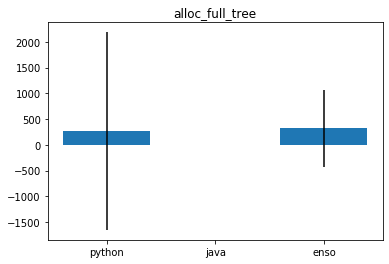

     benchmark language          time        error
2   alloc_list   python  15453.796573  2048.033683
9   alloc_list     java    839.113526    93.254986
16  alloc_list     enso   4298.581719   740.824568


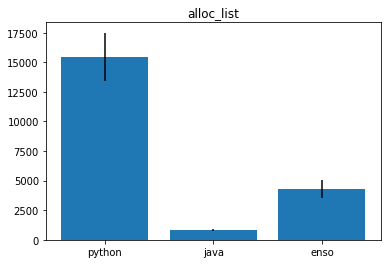

       benchmark language        time      error
3   alloc_vector   python  612.366446   4.456190
10  alloc_vector     java   26.954890   0.366312
17  alloc_vector     enso  999.279343  46.212894


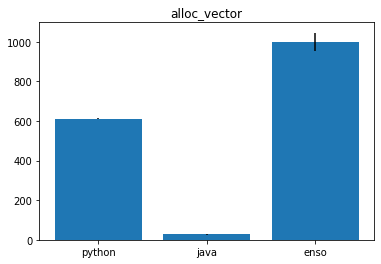

   benchmark language        time     error
4        sum   python  878.030706  7.442026
11       sum     java    4.962264  0.001494
18       sum     enso   13.050992  0.006816


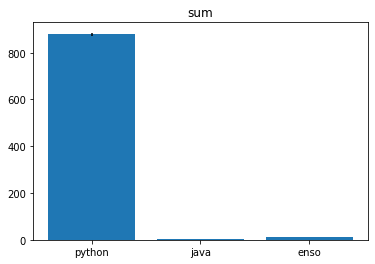

   benchmark language        time     error
5   sum_list   python  960.918656  2.535216
12  sum_list     java   36.539916  0.039989
19  sum_list     enso  205.084142  1.658866


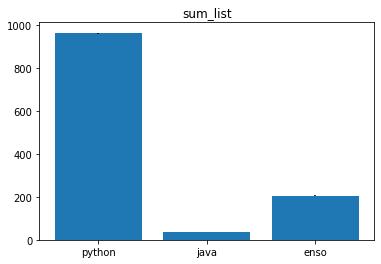

   benchmark language       time     error
6   sum_tree   python  87.455905  1.594365
13  sum_tree     java   1.284832  0.027147
20  sum_tree     enso  25.752960  0.166272


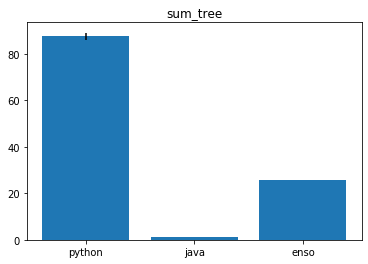

     benchmark language        time     error
7   sum_vector   python  433.351415  0.741415
14  sum_vector     java    9.174569  0.022747
21  sum_vector     enso  276.735559  4.257302


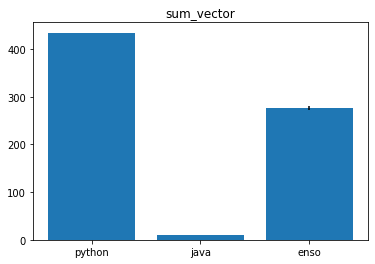

In [15]:
for b in cmp["benchmark"].unique():
    if b == "100ms":
        continue
    part = cmp[cmp["benchmark"] == b]
    print(part)
    plt.bar(x=part["language"], height=part["time"], yerr=part["error"])
    plt.title(b)
    plt.show()

## Information regarding the benchmarks

The basic code is at https://github.com/enso-org/benchmarks/tree/wip/rw/initial-microbenchmarks

For now I have skipped JS and C++ as I don't have a good methodology there. C++ would be doable with some framework, but due to time constraints I couldn't make it. We still compare with Java and C++'s performance on this kind of code should be more-or-less comparable (but of course we should do a good comparison when time allows).

While trying to benchmark Enso, I first was running it in Enso a'la https://github.com/enso-org/enso/tree/main/test/Benchmarks
However as this incurred running different benchmarks in the same JVM and issues with sharing the state of JIT, I tried to repurpose the JMH benchmarks from `runtime` project, that can be found at https://github.com/enso-org/enso/compare/wip/rw/jmh-experiment

So after all I compare Java and Enso using JMH, both are written in a very similar way. They use `avgt` mode which computes average time in milliseconds for operation.

For Python, I run many iterations saving time of each and compute medians (alternatively means) of the timings.

In [22]:
ratios = []
for b in cmp["benchmark"].unique():
    if b == "100ms":
        continue
    part = cmp[cmp["benchmark"] == b]
    ts = part.set_index("language")["time"]
    py = ts.loc["python"] / ts.loc["enso"]
    java = ts.loc["java"] / ts.loc["enso"]
    ratios.append({"benchmark": b, "python/enso": py, "java/enso": java})
ratios = pd.DataFrame.from_records(ratios)
ratios

,benchmark,java/enso,python/enso
0,alloc_full_tree,0.007190,0.832766
1,alloc_list,0.195207,3.595092
2,alloc_vector,0.026974,0.612808
3,sum,0.380221,67.276932
4,sum_list,0.178170,4.685485
5,sum_tree,0.049891,3.395955
6,sum_vector,0.033153,1.565940
